#SimMLA packages

In [0]:
import numpy           as np
from numpy.fft import fft, fftshift, ifft, ifftshift

from scipy.fftpack     import fft, fft2, ifft
from scipy.fftpack     import fftshift, ifftshift
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import simps

import matplotlib.pyplot as plt


In [0]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/FIFIsim/L2_100000/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##fftpack.py

In [0]:
def fftSubgrid(uIn, grid, clip = True):
    '''Computes the 1D FFT of individual subgrids.
    
    fftSubgrid computes the 1D fast Fourier transform of a discretized field in
    each subgrid of a GridArray. This function models the field in the focal plane
    of a single lenslet array using scalar diffraction theory.
        
    Parameters
    ----------
    uIn  : function
        A 1D, real or complex valued function defining an input field
        distribution.
    grid : GridArray
        The grid array for sampling the field.
    clip : bool
        Should the field be clipped in size to the same extent as the initial
        lens aperture? Setting this to False will sample the transformed field
        across the entire computational grid. Setting it to True sets the field
        outside of the aperture to zero.
    
    Returns
    -------
    interpMag   : array of scipy.interpolate.RectBivariateSpline
    interpPhase : array of scipy.interpolate.RectBivariateSpline
    '''
    # Create arrays to hold the interpolations
    interpMag   = []
    interpPhase = []
    
    for subgridX in range(grid.numSubgrids):
        # Sample the field at the grid's real locations
        fieldSample = grid.rect(uIn, subgridX)
        
        # Propagate the field to the MLA
        # fftPropagate(fieldSample, grid, 200e-3)

        # Shift the sample to the center of the coordinate system
        shiftX      = int(grid.subgridCenters[subgridX])
        fieldSample = np.roll(fieldSample, -shiftX)

        # Compute the Fourier transform with appropriate scaling to conserve energy
        scalingFactor = (grid.physicalSize / (grid.gridSize - 1)) \
                      / np.sqrt(grid.wavelength * grid.focalLength)
        F             = scalingFactor * fftshift(fft(ifftshift(fieldSample)))
        
        # Set the field to zero outside of the extent of a single subgrid
        F[np.logical_or(grid.x < -np.floor(grid.subgridSize / 2), grid.x > np.floor(grid.subgridSize / 2))] = 0

        # Shift the grid coordinates back to the original location
        newGridX = grid.pX + (shiftX * grid.physicalSize / grid.gridSize)

        # Find the transform's magnitude and phase for interpolation
        mag   = np.abs(F)
        phase = np.angle(F)
        
        # Interpolate the transform
        # kind = 'linear' SHOULD NOT BE USED. This is because it will introduce
        # artifacts when the phase jumps from zero to +/- pi by interpolating
        # between the jumps.
        interpMag.append(interp1d(newGridX,
                                  mag,
                                  kind         = 'nearest',
                                  bounds_error = False,
                                  fill_value   = 0.0))
        interpPhase.append(interp1d(newGridX,
                                    phase,
                                    kind         = 'nearest',
                                    bounds_error = False,
                                    fill_value   = 0.0))           
            
    return interpMag, interpPhase

def fft2Subgrid(uIn, grid):
    '''Computes the 2D FFT of individual subgrids.
    
    fft2Subgrid computes the 2D fast Fourier transform of a discretized field in
    each subgrid of a GridArray. This function models the field in the focal plane
    of a single lenslet array using scalar diffraction theory.
        
    Parameters
    ----------
    uIn  : function
        A 2D, real or complex valued function defining an input field
        distribution.
    grid : GridArray
        The grid array for sampling the field.
    
    Returns
    -------
    interpMag   : array of scipy.interpolate.RectBivariateSpline
    interpPhase : array of scipy.interpolate.RectBivariateSpline
    '''
    # Create arrays to hold the interpolations
    interpMag   = []
    interpPhase = []
    
    for subgridX in range(grid.numSubgrids):
        for subgridY in range(grid.numSubgrids):
    
            # Sample the field at the grid's real locations
            fieldSample = grid.rect(uIn, subgridX, subgridY)

            # Shift the sample to the center of the coordinate system
            shiftX, shiftY = int(grid.subgridCenters[subgridX]), int(grid.subgridCenters[subgridY])
            fieldSample    = np.roll(np.roll(fieldSample, -shiftX, axis=1), -shiftY, axis = 0)

            # Compute the Fourier transform with appropriate scaling to conserve energy
            scalingFactor = ((grid.physicalSize / (grid.gridSize - 1)) ** 2) \
                          / (grid.wavelength * grid.focalLength)
            F             = scalingFactor * fftshift(fft2(ifftshift(fieldSample)))

            # Shift the grid coordinates back to the original location
            newGridX = grid.pX + (shiftX * grid.physicalSize / grid.gridSize)
            newGridY = grid.pY + (shiftY * grid.physicalSize / grid.gridSize)

            # Find the transform's magnitude and phase for interpolation
            mag   = np.abs(F)
            phase = np.angle(F)

            # Reduce the grid to 1D arrays to use more efficient RectBivariateSpline
            xx = np.sort(np.unique(newGridX))
            yy = np.sort(np.unique(newGridY))

            # Interpolate the transform
            # NOTE: RectBivariateSpline associates X with rows and Y with columns!
            interpMag.append(RectBivariateSpline(yy, xx, mag))
            interpPhase.append(RectBivariateSpline(yy, xx, phase))
    
    return interpMag, interpPhase
    
def fftPropagate(field, grid, propDistance):
    '''Propagates a sampled 1D field along the optical axis.
    
    fftPropagate propagates a sampled 1D field a distance L by computing the
    field's angular spectrum, multiplying each spectral component by the
    propagation kernel exp(j * 2 * pi * fx * L / wavelength), and then
    recomibining the propagated spectral components. The angular spectrum is
    computed using a FFT.
    
    Parameters
    ----------
    field        : 1D array of complex
        The sampled field to propagate.
    grid         : Grid
        The grid on which the sampled field lies.
    propDistance : float
        The distance to propagate the field in the same physical units as the
        grid.
    
    '''
    scalingFactor = (grid.physicalSize / (grid.gridSize - 1))
    F             = scalingFactor * fftshift(fft(ifftshift(field)))
    
    # Compute the z-component of the wavevector
    # Adding 0j ensures that numpy.sqrt returns complex numbers
    kz = 2 * np.pi * np.sqrt(1 - (grid.pfX * grid.wavelength)**2 + 0j) / grid.wavelength
    kz.imag=np.zeros(np.shape(kz))
    #print(kz)
    # Propagate the field's spectral components
    Fprop = F * np.exp(1j * kz * propDistance)
    
    # Recombine the spectral components
    fieldProp = fftshift(ifft(ifftshift(Fprop))) / scalingFactor
    
    return fieldProp

##fields.py

In [0]:
# © All rights reserved. ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE, Switzerland,
# Laboratory of Experimental Biophysics, 2016
# See the LICENSE.docx file for more details.

import numpy as np
from numpy.fft import fft, fftshift, ifft, ifftshift

def GaussianBeamWaistProfile(amplitude, beamStd):
    '''
    Returns
    -------        
    profile : numpy vectorized function
        A function describing the 1D beam profile.
        
    '''
    profile = lambda x: amplitude * np.exp(-x**2 / 2 / beamStd**2)
    profile = np.vectorize(profile)
    
    return profile
    
def GaussianBeamDefocused(amplitude, beamStd, wavelength, position):
    '''Returns the field from a Gaussian beam in an arbitrary plane.
    
    Parameters
    ----------
    amplitude  : float
        The amplitude of the input Gaussian beam.
    beamStd    : float
        The standard deviation of the beam's waist. This is related to the
        waist size through waist = sqrt(2) * beamStd.
    wavelength : float
    position   : float
        The axial position of the observation plane relative to the waist.
    
    '''
    # Compute the beam's waist from the standard deviation
    waist      = np.sqrt(2) * beamStd
    
    wavenumber = 2 * np.pi / wavelength
    
    # Compute the beam radius, curvature, and Gouy phase
    beamRad   = _wz(position, waist, wavelength)
    beamRoc   = _roc(position, waist, wavelength)
    gouyPhase = _gouyPhase(position, waist, wavelength)
    
    profile = lambda x: amplitude * np.sqrt(waist / beamRad) \
                      * np.exp(-x**2 / beamRad**2)  \
                      * np.exp(1j * wavenumber * position \
                             + 1j * wavenumber * x**2 / 2 / beamRoc \
                             - 1j * gouyPhase)
    return profile

def _wz(position, waist, wavelength):
    '''Computes the beam's radius at an arbitrary axial position.
    
    '''
    # Compute the Rayleigh range
    zR = np.pi * waist**2 / wavelength
    
    wz = waist * np.sqrt(1 + (position / zR)**2)
    return wz

def _roc(position, waist, wavelength):
    '''Computes the beam's radius of curvature at an arbitrary axial position.
    
    '''
    # Compute the Rayleigh range
    zR = np.pi * waist**2 / wavelength
    
    if position != 0:
        roc = position * (1 + (zR / position)**2)
    else:
        roc = 0
        
    return roc
    
def _gouyPhase(position, waist, wavelength):
    '''Computes the Gouy phase of the Gaussian beam.
    
    '''
    # Compute the Rayleigh range
    zR = np.pi * waist**2 / wavelength
    
    gouyPhase = np.arctan(position / zR)
    return gouyPhase

def GaussianWithDiffuser(amplitude,
                         beamStd,
                         physicalSize,
                         powerScat  = 0.01,
                         wavelength = 0.642,
                         fc         = 50000,
                         grainSize  = 40,
                         beamSize   = 100):
    '''A Gaussian beam passing through a telescope and rotating diffuser.
    
    Parameters
    ----------
    amplitude : float
        The amplitude of the **input Gaussian beam**, i.e. before the diffuser.
        The amplitude after the diffuser will be calculated from this.
    powerScat : float
        The fractional power scattered by the rotating diffuser. Must lie
        between 0 and 1.
    physicalSize  : float
        The physical size of the grid that the plane waves are defined on.
        This is used for power conservation.
    fc        : float
        The focal length of the collimating lens that collects the light coming
        from the diffuser.
        
    ''' 
    
    # Setup the point sources that model the diffuser
    numSources = np.ceil(beamSize / grainSize)
    srcAmp     = amplitude * np.sqrt(powerScat / numSources * beamStd * np.sqrt(np.pi) / physicalSize)
    srcCenters = np.arange(-numSources * grainSize / 2, numSources * (grainSize / 2) + grainSize, grainSize)

    # Return the deterministic field and scattered plane waves
    return lambda x: _applyDiffuser(x, amplitude, beamStd, srcAmp, srcCenters, powerScat, wavelength, fc)
    
def _applyDiffuser(x, amplitude, beamStd, srcAmp, srcCenters, powerScat, wavelength, fc):
    '''Computes the random plane waves coming from the diffuser.
    
    '''
    # Compute the plane waves' phases and directions
    planewaves = np.zeros(x.size)
    for ctr in range(int(srcCenters.size)):
        randomPhase = np.exp(1j * ((np.random.rand(1) * 2 * np.pi) - np.pi))
        planewaves  = planewaves + srcAmp * np.exp(1j * 2 * np.pi *srcCenters[ctr] * x / wavelength / fc) * randomPhase
        
    # Compute the carrier beam, i.e. the deterministic Gaussian
    newCarrierAmp = amplitude * np.sqrt(1 - powerScat)
    carrierBeam   = GaussianBeamWaistProfile(newCarrierAmp, beamStd)
    
    return carrierBeam(x) + planewaves
    
def GSMBeamRealization(amplitude, beamStd, cohLength, grid):
    '''Returns a single realization of the partially coherent GSM beam.
    
    '''
    # The spatial frequency grid spacing is required for normalizing the random
    # array of the phase screen.
    
    return lambda x: _applyMask(x, amplitude, beamStd, cohLength, grid.pfX)
        
def _applyMask(x, amplitude, beamStd, cohLength, pfX):
    '''Computes the random phase mask at the grid locations.
    
    '''
    dx      = x[1] - x[0] # Assumes uniform spacing between samples
    dpfX    = pfX[1] - pfX[0]
    
    # Define phase screen parameters
    sigma_f = 2.5 * cohLength
    sigma_r = np.sqrt(4 * np.pi * sigma_f**4 / cohLength**2)

    # Convolve phase screen functions
    F = ifftshift(np.exp(-np.pi**2 * sigma_f**2 * pfX**2));
    R = np.random.randn(x.size) + 1.0j * np.random.randn(x.size)
    
    # From Voelz, "Computational Fourier Optics: A MATLAB Tutorial", Chap. 9
    phaseScreen = 2 * np.pi * fftshift(ifft(F*R)) * sigma_r / (dx * np.sqrt(dpfX))
    
    # Sample the field
    fieldFunc = GaussianBeamWaistProfile(amplitude, beamStd)
    field = fieldFunc(x) * np.exp(1.0j * np.real(phaseScreen))
    
    return field
    
def diffuserMask(sigma_f, sigma_r, grid):
    '''Returns a single realization of the partially coherent GSM beam.
    
    '''
    # The spatial frequency grid spacing is required for normalizing the random
    # array of the phase screen.
    
    return lambda x: _applyDiffuserMask(x, sigma_f, sigma_r, grid.pfX)
        
def _applyDiffuserMask(x, sigma_f, sigma_r, pfX):
    '''Computes the random phase mask at the grid locations.
    
    Notes
    -----
    Partially coherent beam simulation from Xifeng Xiao and David Voelz,
    "Wave optics simulation approach for partial spatially coherent beams."
    Opt. Express 14, 6986-6992 (2006)
    
    '''
    dx      = x[1] - x[0] # Assumes uniform spacing between samples
    dpfX    = pfX[1] - pfX[0]

    # Convolve phase screen functions
    F = ifftshift(np.exp(-np.pi**2 * sigma_f**2 * pfX**2));
    R = np.random.randn(x.size) + 1.0j * np.random.randn(x.size)
    
    # From Voelz, "Computational Fourier Optics: A MATLAB Tutorial", Chap. 9
    phaseScreen = 2 * np.pi * fftshift(ifft(F*R)) * sigma_r / (dx * np.sqrt(dpfX))
    
    # Sample the field
    mask = np.exp(1.0j * np.real(phaseScreen))
    
    return mask

##grids.py

In [0]:
# © All rights reserved. ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE, Switzerland,
# Laboratory of Experimental Biophysics, 2016
# See the LICENSE.docx file for more details.

import numpy as np

# Function definitions
def isEven(x):
    return (x % 2 == 0)
    
# Class definitions
class ImproperDimensionException(Exception):
    pass    

class ImproperGridSizeException(Exception):
    pass

class Grid(object):
    def __init__(self, gridSize, physicalSize, wavelength, focalLength, dim = 2):
        '''Establishes a square grid for sampling an electromagnetic field.
        
        The grid is square with an odd number of grid locations along one
        linear dimension. It is centered at (0,0) and may be converted into
        physical units for easily sampling known field distributions.
        
        Lowercase letters are used for real units; Uppercase for Fourier
        transform units.
        
        Parameters
        ----------
        gridSize     : int
            The size of the square grid in units of grid locations.
            Must be an odd integer.
        physicalSize : float
            The full linear extent of the grid in physical units.
        wavelength   : float
            The wavelength of the EM field.
        focalLength  : float
            The focal length of the lens used to compute units of
            the Fourier transform.
        dim          : int
            The dimension of the grid (can be 1 or 2).
            
        '''
        if (not isinstance(gridSize, int)) or isEven(gridSize) or (gridSize <= 0):
            raise ImproperGridSizeException('gridSize parameter is not an odd, positive integer.')
        
        self.gridSize     = gridSize
        self.physicalSize = physicalSize
        self.wavelength   = wavelength
        self.focalLength  = focalLength
        
        coords = np.arange(-np.floor(gridSize / 2), (np.floor(gridSize / 2)) + 1)
        
        # Create the grid
        if dim == 2:
            self.x, self.y = np.meshgrid(coords, coords)
        elif dim == 1:
            self.x = coords
        else:
            raise ImproperDimensionException('dim must be an integer equal to 1 or 2.')
        
        # Setup the conversion factors
        self._gridToPhys         = self.physicalSize / (self.gridSize - 1)
        self._gridToFTGrid       = 1 / self.gridSize
        self._gridToPhysFTGrid   = 1 / self.physicalSize
    
    @property
    def px(self):
        '''Return the x-grid in physical units.
        
        '''
        return self.x * self._gridToPhys
    
    @property
    def py(self):
        '''Return the y-grid in physical units.
        
        '''
        return self.y * self._gridToPhys
    
    @property
    def X(self):
        '''Return the X-grid of the Fourier transform.
        
        '''
        return self.x * self._gridToFTGrid
    
    @property
    def Y(self):
        '''Return the Y-grid of the Fourier transform.
        
        '''
        return self.y * self._gridToFTGrid
    
    @property
    def pX(self):
        '''Return the X-grid of the Fourier transform in physical units.
        
        Units are wavelength * (focal length) / (physical size).
        '''
        return self.x * self.wavelength * self.focalLength * self._gridToPhysFTGrid
    
    @property
    def pY(self):
        '''Return the Y-grid of the Fourier transform in physical units.
        
        Units are wavelength * (focal length) / (physical size).
        '''
        return self.y * self.wavelength * self.focalLength * self._gridToPhysFTGrid
        
    @property
    def pfX(self):
        '''Return the X-grid of the Fourier transform in spatial frequencies.
        
        This is spatial frequency fx = x' / (wavelength * focalLength).
        '''
        return self.x * self._gridToPhysFTGrid
    
    @property
    def pfY(self):
        '''Return the X-grid of the Fourier transform in spatial frequencies.
        
        This is spatial frequency fy = y' / (wavelength * focalLength).
        '''
        return self.y * self._gridToPhysFTGrid
        
class GridArray(Grid):
    '''An array of grids on a fixed coordinate system.
    
    The grid array facilitates building a square array of non-overlapping square grids
    by managing the placement of the subgrids on a fixed coordinate system.
    
    '''
    def __init__(self, numSubgrids, subgridSize, physicalSize, wavelength, focalLength, dim = 2, zeroPad = 3):
        '''Builds an array of grids all lying on a common coordinate system.
        
        Parameters
        ----------
        numSubgrids : int
            The number of subgrids in the full coordinate system. Must be odd.
        subGridSize : int
            The linear size of a square subgrid. Must be odd.
        physicalSize : float
            The size of the full grid in physical units.
        wavelength : float
            The wavelength of the light for computing the grid of the Fourier transform.
        focalLength : float
            The focal length of the lens for computing the grid of the Fourier transform.
        dim          : int
            The dimension of the grid (can be 1 or 2).
        zeroPad      : int (odd)
            The size of the grid will be increased beyond the set bounds by
            this factor. For example, if the physical size of the grid was set
            to 1 mm and zeropad was to 5, the actual simulation grid will be 5
            times larger and the physical size will be 5 mm, with 2 mm worth of
            zeros on both sides of the subgrid.
       
        ''' 
        if (not isinstance(numSubgrids, int)) or isEven(numSubgrids) or (numSubgrids <= 0):
            raise ImproperGridSizeException('numSubgrids parameter is not an odd, positive integer.')
            
        if (not isinstance(subgridSize, int)) or isEven(subgridSize) or (subgridSize <= 0):
            raise ImproperGridSizeException('subgridSize parameter is not an odd, positive integer.')

        self.numSubgrids = numSubgrids
        self.subgridSize = subgridSize    
        
        # Build the common coordinate system
        gridSize = zeroPad * numSubgrids * subgridSize
        super(GridArray, self).__init__(gridSize, zeroPad * physicalSize, wavelength, focalLength, dim = dim)
        
        # Set the centers of the subgrids. They will only exist in the
        # non-zeropadded regions
        self.subgridCenters = subgridSize * np.arange(-np.floor(numSubgrids / 2), np.floor(numSubgrids / 2) + 1)
        self.subgridx, self.subgridy = np.meshgrid(self.subgridCenters, self.subgridCenters)
        
    def rect(self, fieldIn, xInd):
        '''Samples an input 1D field on the given subgrid.
        
        Parameters
        ----------
        fieldIn : function
            A 2D, real or complex valued function defining an input field distribution.
        xInd    : int
            x-index (column) of the subgrid.
        
        Returns
        -------
        fieldSample : 1D array of complex
            The input field on the given subgrid.
            
        '''
        xCenter = self.subgridCenters[xInd]
        
        # Sample the field onto the grid
        fieldSample = fieldIn(self.px)
        
        # Create a mask centered on the specified subgrid
        sgHalfSize = np.floor(self.subgridSize / 2)
        mask       = np.logical_and(self.x >= (xCenter - sgHalfSize), (self.x <= xCenter + sgHalfSize))

        # Return the sampled and masked field
        return fieldSample * mask.astype(int)
    
    def rect2(self, fieldIn, xInd, yInd):
        '''Samples an input 2D field at the given subgrid.
        
        Parameters
        ----------
        fieldIn : function
            A 2D, real or complex valued function defining an input field distribution.
        xInd    : int
            x-index (column) of the subgrid.
        yInd    : int
            y-index (row) of the subgrid.
        
        Returns
        -------
        fieldSample : 2D array of complex
            The input field at the given subgrid.
            
        '''
        xCenter, yCenter = self.subgridCenters[xInd], self.subgridCenters[yInd]
        
        # Sample the field onto the grid
        fieldSample = fieldIn(self.px, self.py)
        
        # Create a mask centered on the specified subgrid
        sgHalfSize = np.floor(self.subgridSize / 2)
        maskX      = np.logical_and(self.x >= (xCenter - sgHalfSize), (self.x <= xCenter + sgHalfSize))
        maskY      = np.logical_and(self.y >= (yCenter - sgHalfSize), (self.y <= yCenter + sgHalfSize))
        mask       = np.logical_and(maskX, maskY)

        # Return the sampled and masked field
        return fieldSample * mask.astype(int)

#Simulation environment

##Build the system

In [0]:
numLenslets = 33     # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 300    # microns
focalLength = 2200 / (1.47 - 1)  # microns, lenslet focal lengths
fc          = 60000  # microns, collimating lens focal length
dR          = -5000  # microns, distance of diffuser from telescope focus
L1          = 5000 # microns, distance between collimating lens and first MLA
L2          = 0 # microns, distance between second MLA and objective BFP
wavelength  = 0.561 # microns

f_BE1 = 120000
f_BE2 = 60000

subgridSize  = 2001 # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
collGrid = Grid(50001, 25000, wavelength, fc, dim = 1)
BE1Grid = Grid(50001, 50000, wavelength, f_BE1, dim = 1)
BE2Grid = Grid(50001, 25000, wavelength, f_BE2, dim = 1)

grid     = GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)
primaryGrid = GridArray(109, 2001, 109*222, wavelength, 6000, dim=1, zeroPad=3) # N = 24 mm / 0.222 mm per lenslet
#primaryGrid = grids.GridArray(109, 1001, 24000, wavelength, 6000, dim=1, zeroPad=3) # N = 24 mm / 0.222 mm per lenslet


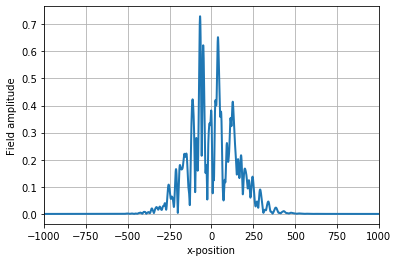

In [0]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 6    # microns
sigma_f         = 10   # microns, diffuser correlation length
sigma_r         = 1.75 # variance of the random phase
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

# The diffuser sits 'dR' microns from the focus
beam     = lambda x: GaussianBeamDefocused(fieldAmp, beamStd, wavelength, dR)(x) \
                   * diffuserMask(sigma_f, sigma_r, collGrid)(x)
# Sample the beam at the diffuser
beamSample = beam(collGrid.px)

# Propagate the sample back to the focal plane of the telescope
beamSample = fftPropagate(beamSample, collGrid, -dR)

plt.plot(collGrid.px, np.abs(beamSample), linewidth = 2)
plt.xlim((-1000,1000))
plt.xlabel(r'x-position')
plt.ylabel(r'Field amplitude')
plt.grid(True)
plt.show()

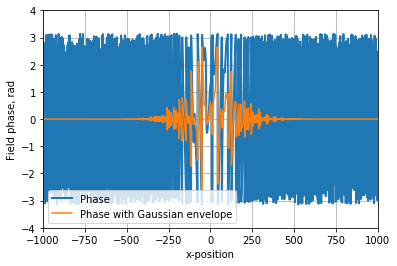

In [0]:
plt.plot(collGrid.px, np.angle(beamSample), linewidth = 2, label ='Phase')
plt.plot(collGrid.px, np.abs(beamSample) / np.max(np.abs(beamSample)) * np.angle(beamSample), label = 'Phase with Gaussian envelope')
plt.xlim((-1000,1000))
plt.ylim((-4, 4))
plt.xlabel(r'x-position')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.legend()
plt.show()

##Create the input fields for the MLAs

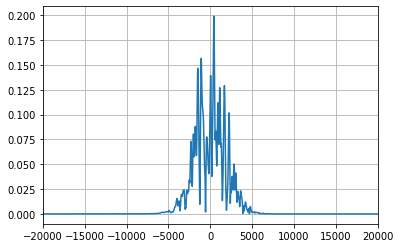

In [0]:
scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
inputField    = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beamSample)))
plt.plot(collGrid.pX, np.abs(inputField))
plt.xlim((-20000, 20000))
plt.grid(True)
plt.show()

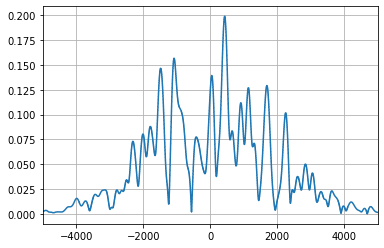

In [0]:
# Interpolate this field onto the MLA grid
mag = np.abs(inputField)
ang = np.angle(inputField)

inputMag = interp1d(collGrid.pX,
                    mag,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)
inputAng = interp1d(collGrid.pX,
                    ang,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)

plt.plot(grid.px, np.abs(inputMag(grid.px) * np.exp(1j * inputAng(grid.px))))
plt.xlim((-5000, 5000))
plt.grid(True)
plt.show()

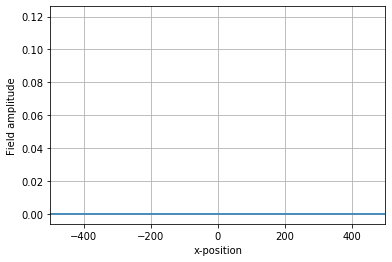

In [0]:
field2 = lambda x: inputMag(x) * np.exp(1j * inputAng(x))
interpMag, interpAng = fftSubgrid(field2, grid)

# Plot the field behind the second MLA center lenslet
plt.plot(grid.pX, np.abs(interpMag[5](grid.pX) * np.exp(1j * interpAng[10](grid.pX))))
plt.xlim((-500, 500))
plt.xlabel('x-position')
plt.ylabel('Field amplitude')
plt.grid(True)
plt.show()

##Propagate this field and its many realizations

In [0]:
fObj    = 300000 # microns
bfpDiam = 50000  # microns, BFP diameter, 2 * NA * f_OBJ

# Grid for interpolating the field after the second MLA
newGridSize = subgridSize * numLenslets # microns
#newGrid     = Grid(50001, physicalSize, wavelength, fObj, dim = 1)
newGrid     = Grid(3*newGridSize, 3*physicalSize, wavelength, fObj, dim = 1)

Realization number: 0
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.01 mW
4 The output power is 100.00 mW
5 The output power is 99.87 mW
6 The output power is 98.53 mW
7 The output power is 98.53 mW
8 The output power is 98.53 mW
9 The output power is 94.84 mW


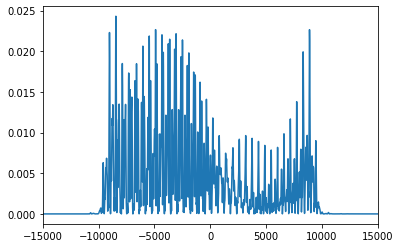

Realization number: 1
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.01 mW
4 The output power is 100.01 mW
5 The output power is 99.81 mW
6 The output power is 98.63 mW
7 The output power is 98.63 mW
8 The output power is 98.63 mW
9 The output power is 94.76 mW


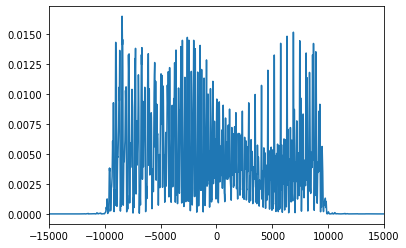

Realization number: 2
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.83 mW
6 The output power is 98.58 mW
7 The output power is 98.58 mW
8 The output power is 98.58 mW
9 The output power is 94.77 mW


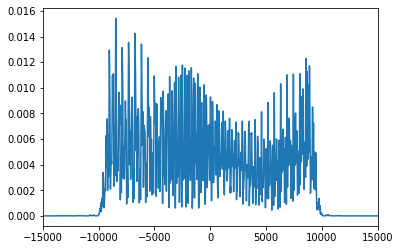

Realization number: 3
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.83 mW
6 The output power is 98.64 mW
7 The output power is 98.64 mW
8 The output power is 98.64 mW
9 The output power is 94.84 mW


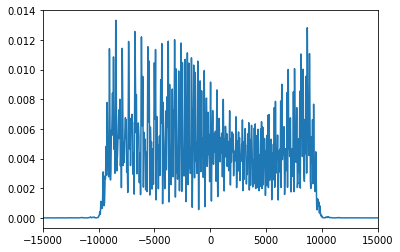

Realization number: 4
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.63 mW
7 The output power is 98.63 mW
8 The output power is 98.63 mW
9 The output power is 94.79 mW


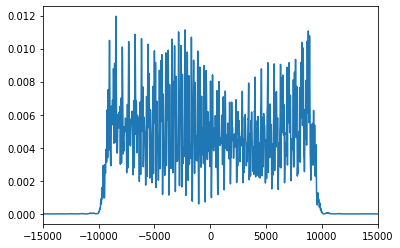

Realization number: 5
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.67 mW
7 The output power is 98.67 mW
8 The output power is 98.67 mW
9 The output power is 94.83 mW


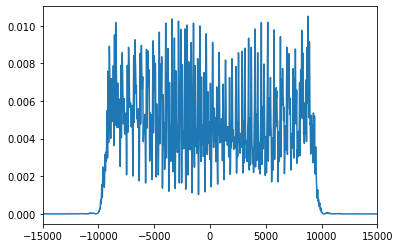

Realization number: 6
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.76 mW
9 The output power is 94.94 mW


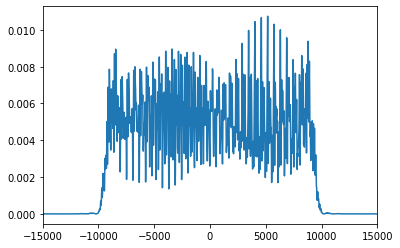

Realization number: 7
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.69 mW
7 The output power is 98.69 mW
8 The output power is 98.69 mW
9 The output power is 94.88 mW


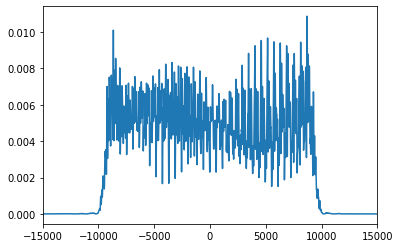

Realization number: 8
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.75 mW
7 The output power is 98.75 mW
8 The output power is 98.75 mW
9 The output power is 94.96 mW


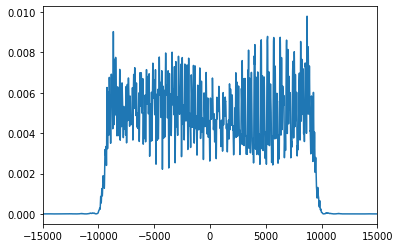

Realization number: 9
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.73 mW
7 The output power is 98.73 mW
8 The output power is 98.73 mW
9 The output power is 94.93 mW


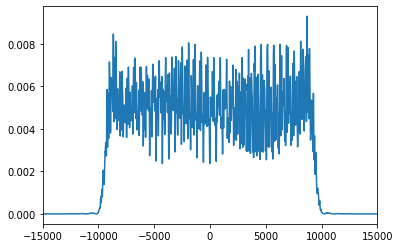

Realization number: 10
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.71 mW
7 The output power is 98.71 mW
8 The output power is 98.71 mW
9 The output power is 94.88 mW


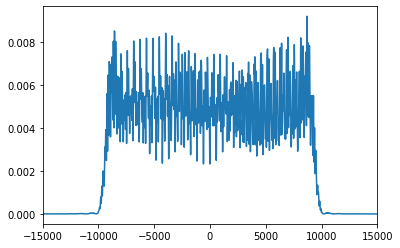

Realization number: 11
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.72 mW
7 The output power is 98.72 mW
8 The output power is 98.72 mW
9 The output power is 94.89 mW


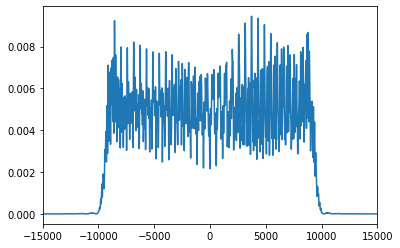

Realization number: 12
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.90 mW


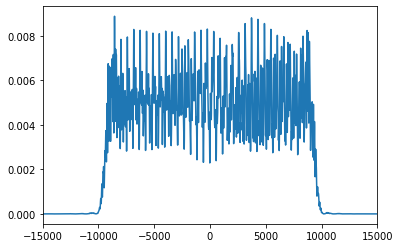

Realization number: 13
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.77 mW
9 The output power is 94.92 mW


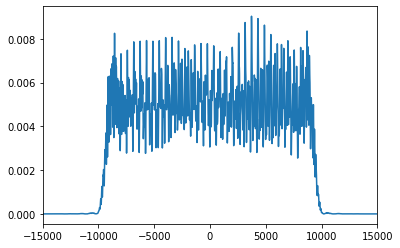

Realization number: 14
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.76 mW
9 The output power is 94.91 mW


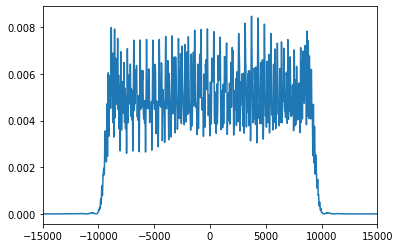

Realization number: 15
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.94 mW


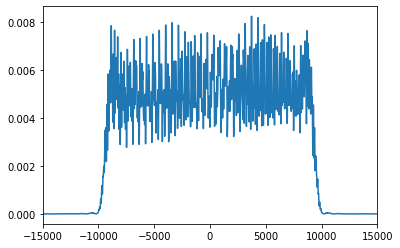

Realization number: 16
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.93 mW


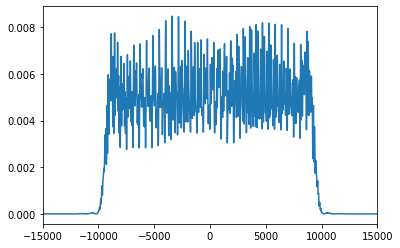

Realization number: 17
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.93 mW


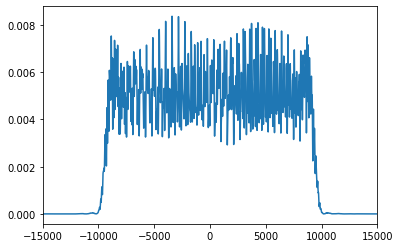

Realization number: 18
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.94 mW


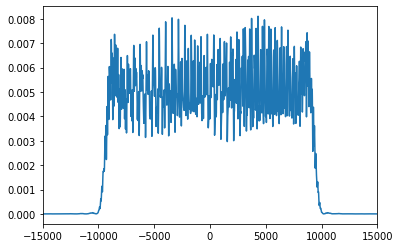

Realization number: 19
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.95 mW


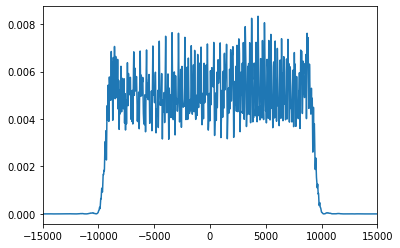

Realization number: 20
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.82 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.96 mW


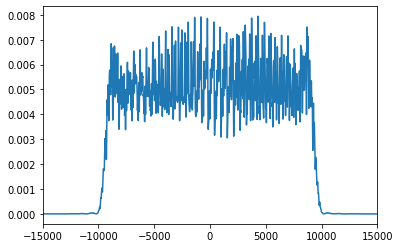

Realization number: 21
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.88 mW


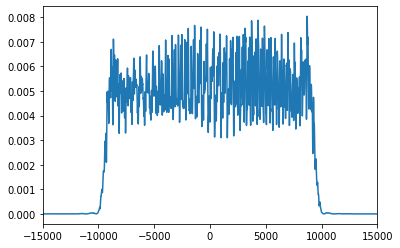

Realization number: 22
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.89 mW


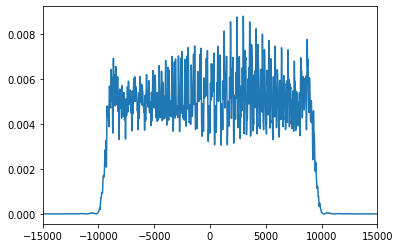

Realization number: 23
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


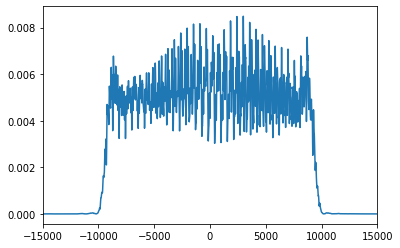

Realization number: 24
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


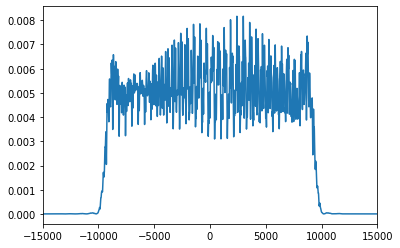

Realization number: 25
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.94 mW


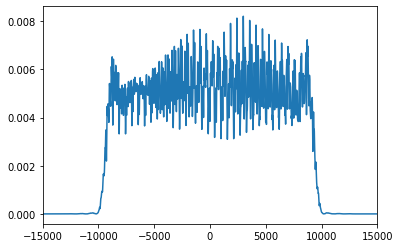

Realization number: 26
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.83 mW
7 The output power is 98.83 mW
8 The output power is 98.83 mW
9 The output power is 94.96 mW


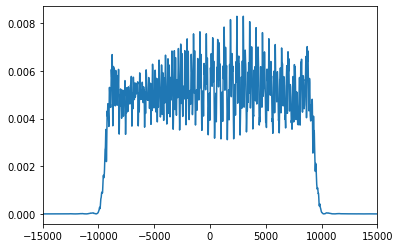

Realization number: 27
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.82 mW
7 The output power is 98.82 mW
8 The output power is 98.82 mW
9 The output power is 94.95 mW


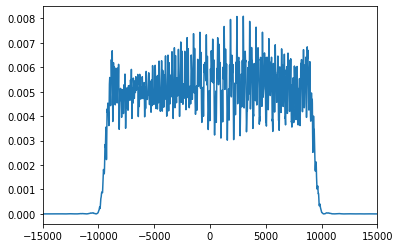

Realization number: 28
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.91 mW


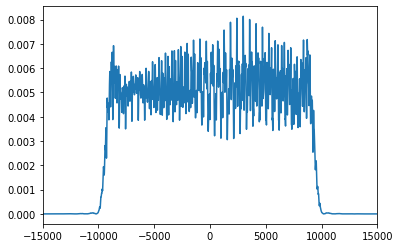

Realization number: 29
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.91 mW


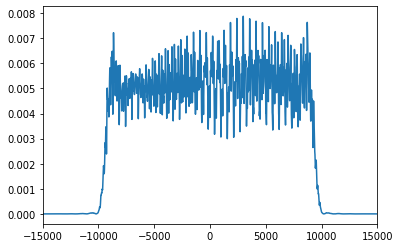

Realization number: 30
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.92 mW


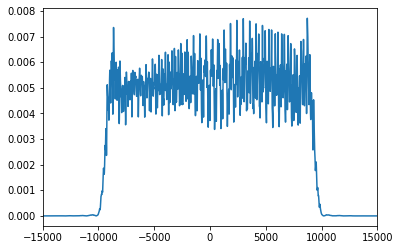

Realization number: 31
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.91 mW


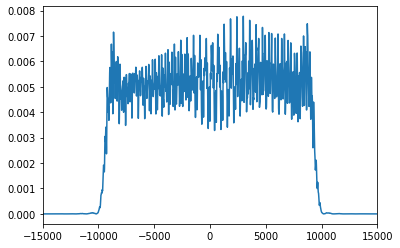

Realization number: 32
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.91 mW


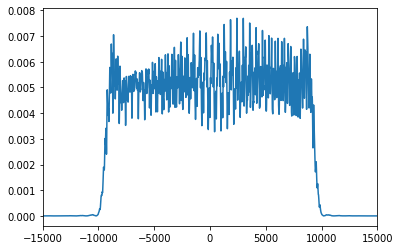

Realization number: 33
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.93 mW


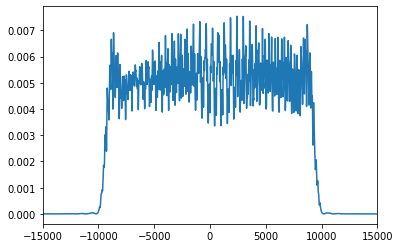

Realization number: 34
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.94 mW


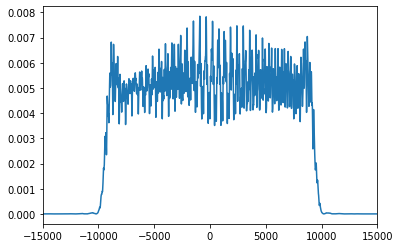

Realization number: 35
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


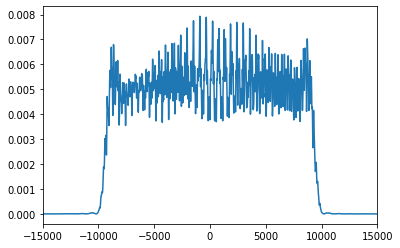

Realization number: 36
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


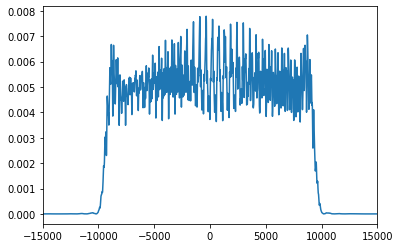

Realization number: 37
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.82 mW
7 The output power is 98.82 mW
8 The output power is 98.82 mW
9 The output power is 94.94 mW


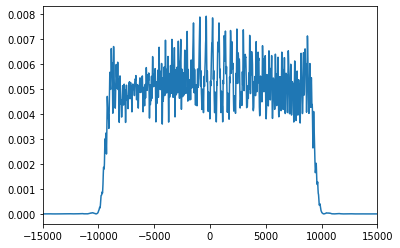

Realization number: 38
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.92 mW


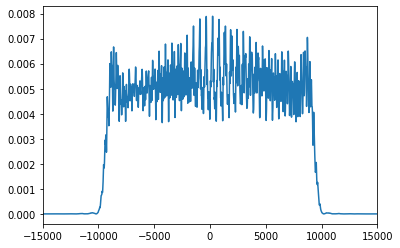

Realization number: 39
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.92 mW


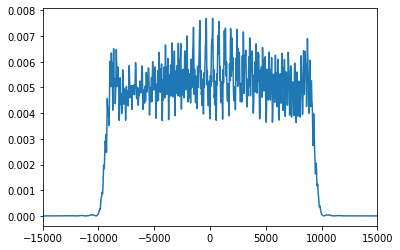

Realization number: 40
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.92 mW


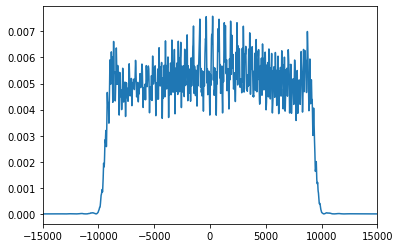

Realization number: 41
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.92 mW


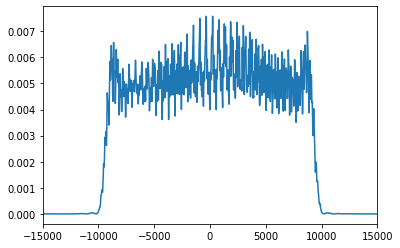

Realization number: 42
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


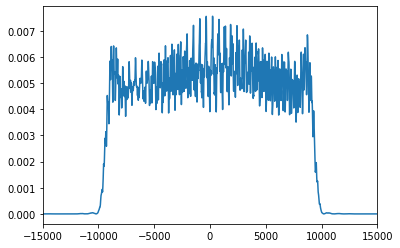

Realization number: 43
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


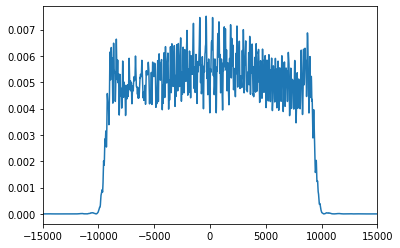

Realization number: 44
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.81 mW
7 The output power is 98.81 mW
8 The output power is 98.81 mW
9 The output power is 94.93 mW


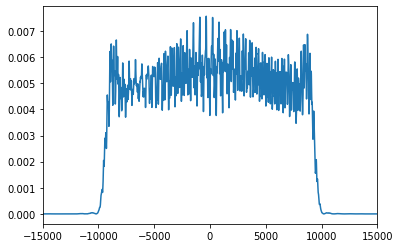

Realization number: 45
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.92 mW


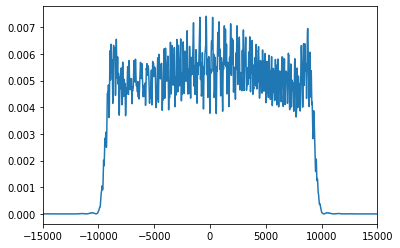

Realization number: 46
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.92 mW


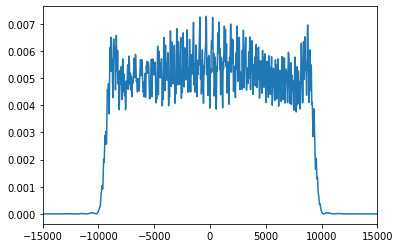

Realization number: 47
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.92 mW


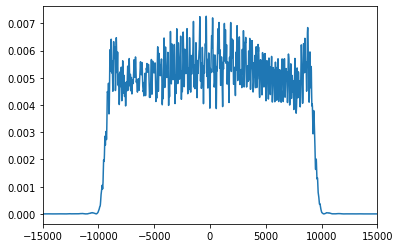

Realization number: 48
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.80 mW
7 The output power is 98.80 mW
8 The output power is 98.80 mW
9 The output power is 94.93 mW


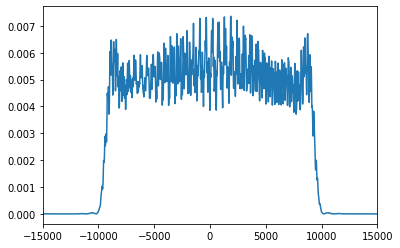

Realization number: 49
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.91 mW


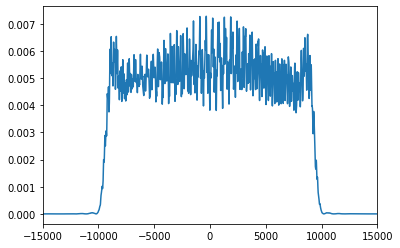

Realization number: 50
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.90 mW


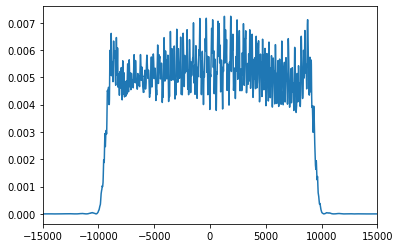

Realization number: 51
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.89 mW


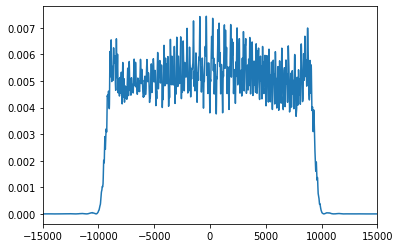

Realization number: 52
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.89 mW


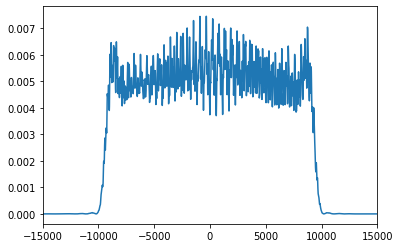

Realization number: 53
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.89 mW


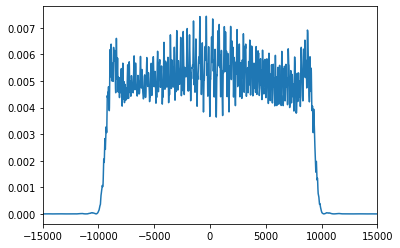

Realization number: 54
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.89 mW


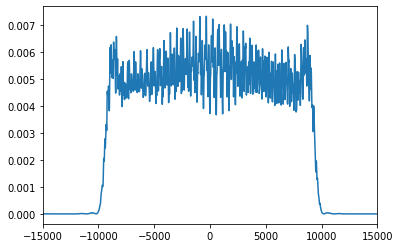

Realization number: 55
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.90 mW


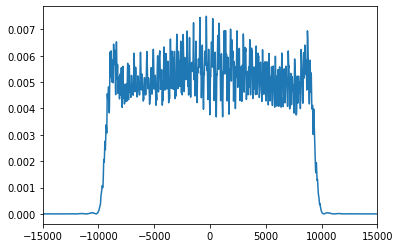

Realization number: 56
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.90 mW


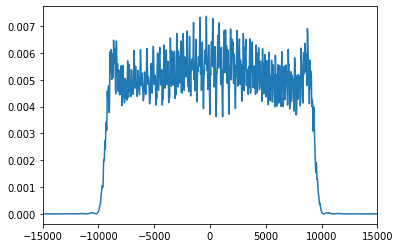

Realization number: 57
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.91 mW


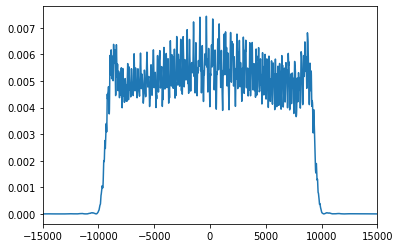

Realization number: 58
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.92 mW


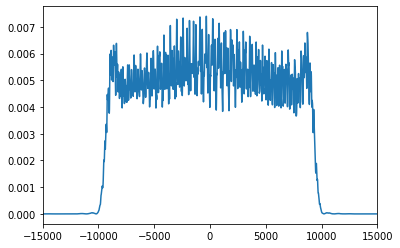

Realization number: 59
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.81 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.92 mW


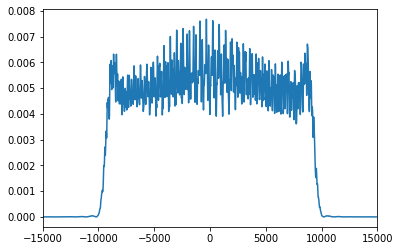

Realization number: 60
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.88 mW


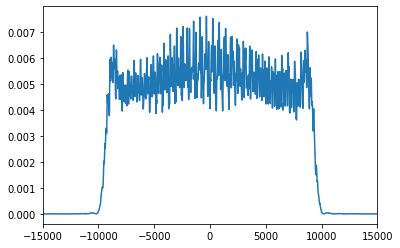

Realization number: 61
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.88 mW


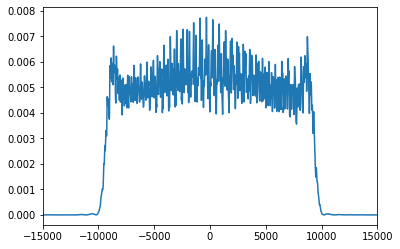

Realization number: 62
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.88 mW


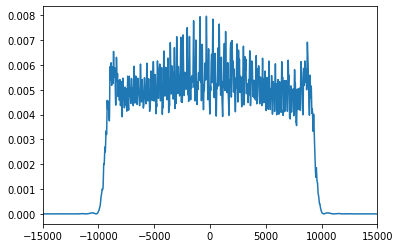

Realization number: 63
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.87 mW


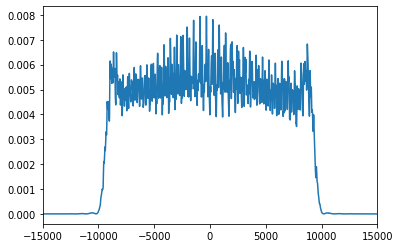

Realization number: 64
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.87 mW


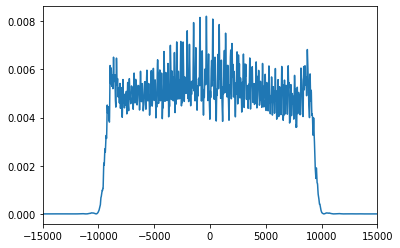

Realization number: 65
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.79 mW
7 The output power is 98.79 mW
8 The output power is 98.79 mW
9 The output power is 94.88 mW


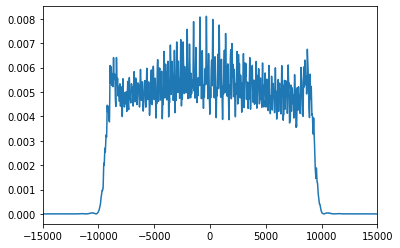

Realization number: 66
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.88 mW


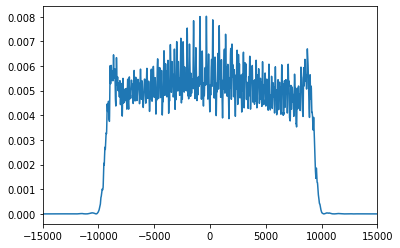

Realization number: 67
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.88 mW


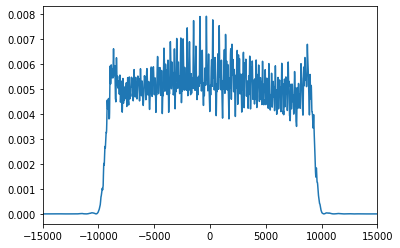

Realization number: 68
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.78 mW
9 The output power is 94.86 mW


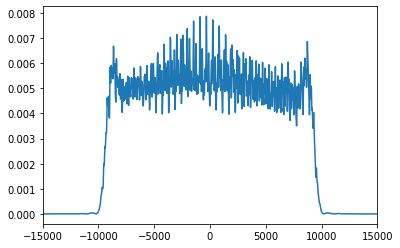

Realization number: 69
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.78 mW
7 The output power is 98.78 mW
8 The output power is 98.78 mW
9 The output power is 94.87 mW


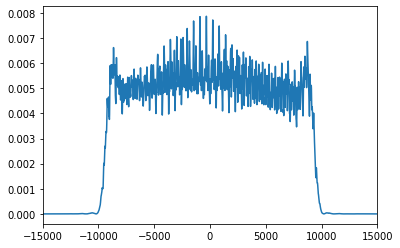

Realization number: 70
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.86 mW


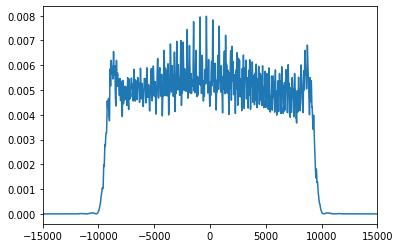

Realization number: 71
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.86 mW


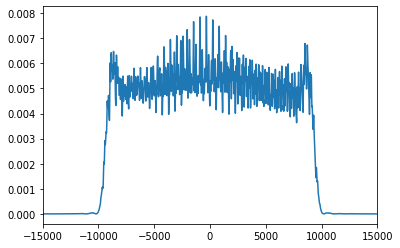

Realization number: 72
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.87 mW


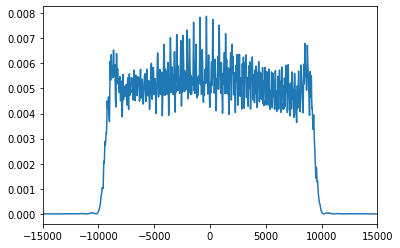

Realization number: 73
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.87 mW


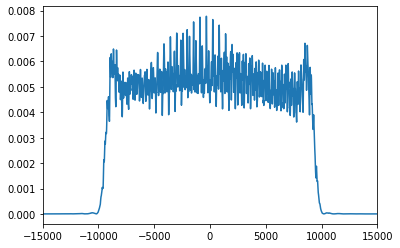

Realization number: 74
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.87 mW


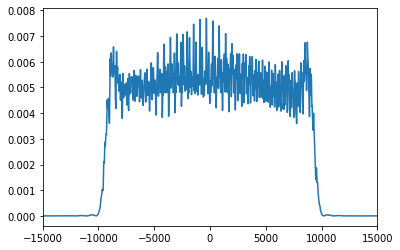

Realization number: 75
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.87 mW


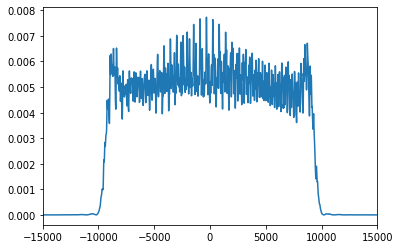

Realization number: 76
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.88 mW


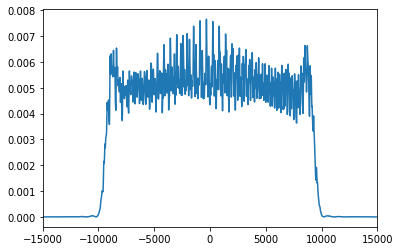

Realization number: 77
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.76 mW
9 The output power is 94.86 mW


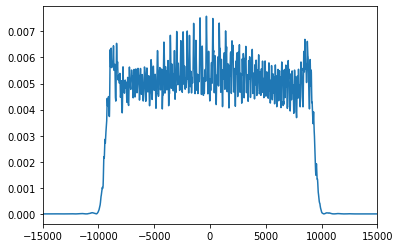

Realization number: 78
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.77 mW
7 The output power is 98.77 mW
8 The output power is 98.77 mW
9 The output power is 94.87 mW


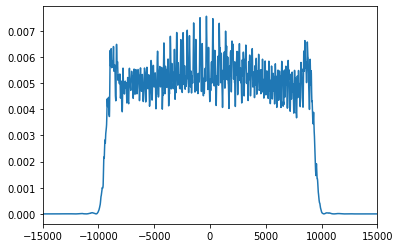

Realization number: 79
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.76 mW
9 The output power is 94.86 mW


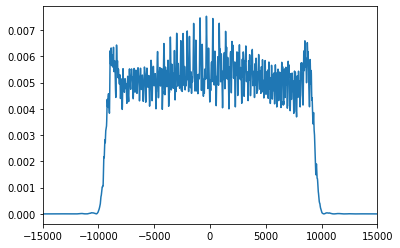

Realization number: 80
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.76 mW
7 The output power is 98.76 mW
8 The output power is 98.76 mW
9 The output power is 94.85 mW


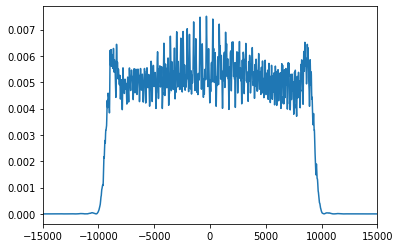

Realization number: 81
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.75 mW
7 The output power is 98.75 mW
8 The output power is 98.75 mW
9 The output power is 94.83 mW


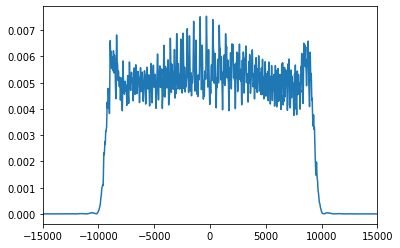

Realization number: 82
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.83 mW


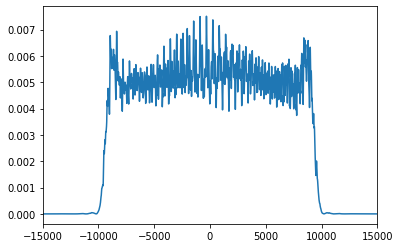

Realization number: 83
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


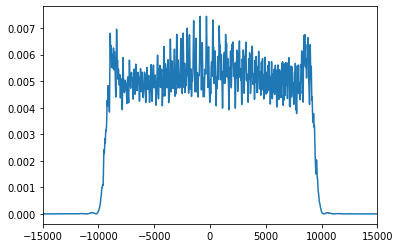

Realization number: 84
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.81 mW


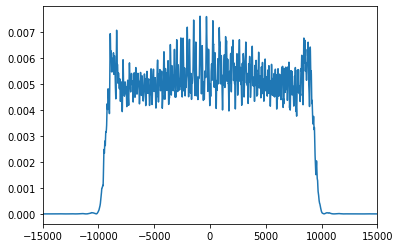

Realization number: 85
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


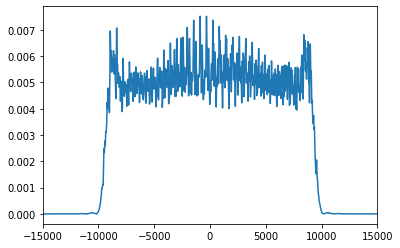

Realization number: 86
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


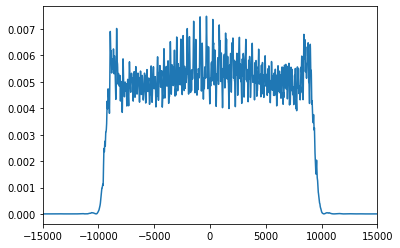

Realization number: 87
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


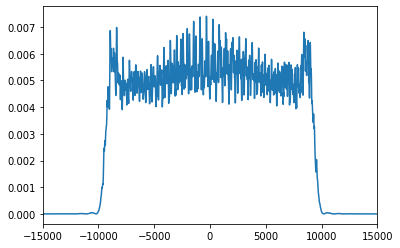

Realization number: 88
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.83 mW


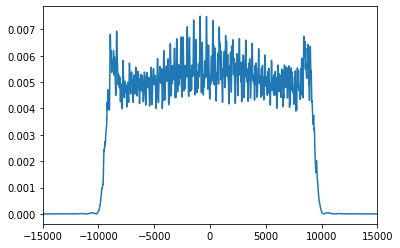

Realization number: 89
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


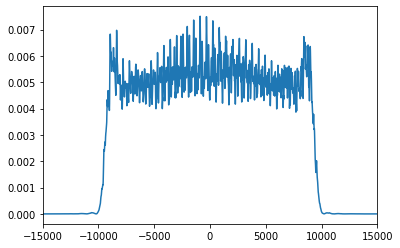

Realization number: 90
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.83 mW


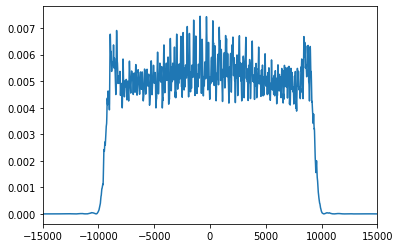

Realization number: 91
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.75 mW
7 The output power is 98.75 mW
8 The output power is 98.75 mW
9 The output power is 94.83 mW


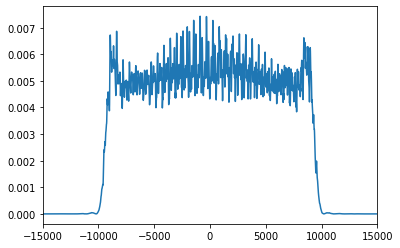

Realization number: 92
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.75 mW
7 The output power is 98.75 mW
8 The output power is 98.75 mW
9 The output power is 94.83 mW


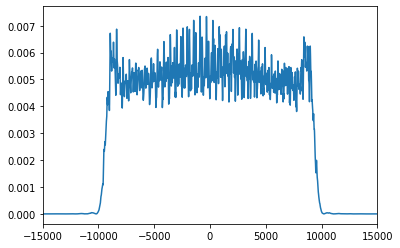

Realization number: 93
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.82 mW


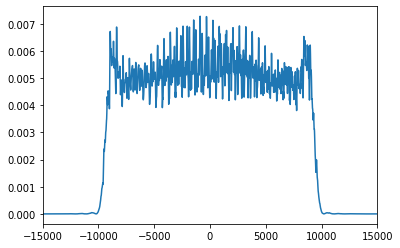

Realization number: 94
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.81 mW


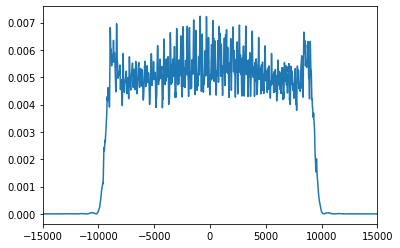

Realization number: 95
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.80 mW


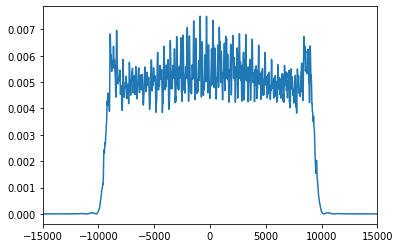

Realization number: 96
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.73 mW
7 The output power is 98.73 mW
8 The output power is 98.74 mW
9 The output power is 94.79 mW


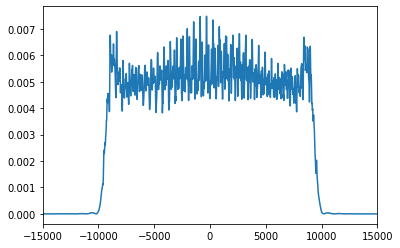

Realization number: 97
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.80 mW


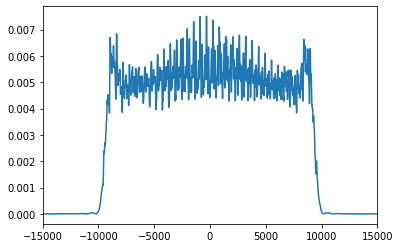

Realization number: 98
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.80 mW


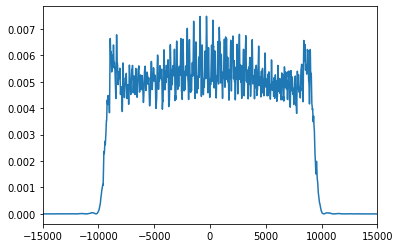

Realization number: 99
1 The output power is 100.00 mW
2 The output power is 100.00 mW
3 The output power is 100.00 mW
4 The output power is 100.00 mW
5 The output power is 99.80 mW
6 The output power is 98.74 mW
7 The output power is 98.74 mW
8 The output power is 98.74 mW
9 The output power is 94.80 mW


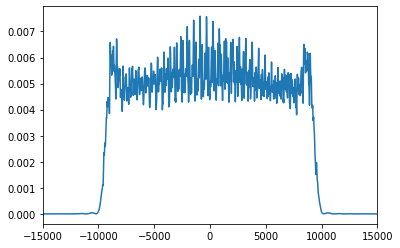

In [0]:
nIter   = 100
       
# New phase mask; the diffuser sits 'dR' microns from the focus
beam = lambda x: GaussianBeamDefocused(fieldAmp, beamStd, wavelength, dR)(x) \
               * diffuserMask(sigma_f, sigma_r, collGrid)(x)

avgIrrad0 = np.zeros(collGrid.px.size, dtype=np.float128)
avgIrradCol = np.zeros(collGrid.pX.size, dtype=np.float128)
avgIrradBE1 = np.zeros(BE1Grid.pX.size, dtype=np.float128)
avgIrradBE2 = np.zeros(BE2Grid.pX.size, dtype=np.float128)
avgIrrad1 = np.zeros(grid.px.size, dtype=np.float128)


avgIrrad2 = np.zeros(newGrid.px.size, dtype=np.float128)
avgIrrad3 = np.zeros(newGrid.px.size, dtype=np.float128)
avgIrrad4 = np.zeros(newGrid.pX.size, dtype=np.float128)
avgIrrad5 = np.zeros(primaryGrid.px.size, dtype=np.float128)

for realization in range(nIter):
    print('Realization number: {0:d}'.format(realization))

    # Propagate the field from the diffuser to the telescope focus
    beamSample = beam(collGrid.px)
    beamSample = fftPropagate(beamSample, collGrid, -dR)

    avgIrrad0 = avgIrrad0 + np.abs(beamSample)**2 / Z0 * 1000

    # Compute the field in the focal plane of the collimating lens
    scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
    afterColl     = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beamSample)))
    #avgIrradCol = avgIrradCol + np.abs(afterColl)**2 / Z0 * 1000

    # Interpolate the input onto the new grid;
    # Propagate it to the first MLA at distance L1 away from the focal plane of the collimating lens
    inputMag = interp1d(collGrid.pX,
                        np.abs(afterColl),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputAng = interp1d(collGrid.pX,
                        np.angle(afterColl),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputField = lambda x: (inputMag(x) * np.exp(1j * inputAng(x)))
    avgIrradCol = avgIrradCol + np.abs(inputField(collGrid.pX))**2 / Z0 * 1000
    #print(inputField)
    # Apply beam expander
    #afterCollProp = fftPropagate(afterColl, collGrid, -180000)
    scalingFactor1 = BE1Grid.physicalSize / (BE1Grid.gridSize - 1) / np.sqrt(BE1Grid.wavelength * BE1Grid.focalLength)
    afterBE1     = scalingFactor1 * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(inputField(BE1Grid.px))))
    #avgIrradBE1 = avgIrradBE1 + np.abs(afterBE1)**2 / Z0 * 1000
    
    inputMag1 = interp1d(BE1Grid.pX,
                        np.abs(afterBE1),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputAng1 = interp1d(BE1Grid.pX,
                        np.angle(afterBE1),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputField1 = lambda x: (inputMag1(x) * np.exp(1j * inputAng1(x)))
    avgIrradBE1 = avgIrradBE1 + np.abs(inputField1(BE1Grid.pX))**2 / Z0 * 1000

    
    scalingFactor2 = BE2Grid.physicalSize / (BE2Grid.gridSize - 1) / np.sqrt(BE2Grid.wavelength * BE2Grid.focalLength)
    afterBE2     = scalingFactor2 * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(inputField1(BE2Grid.px))))
    #avgIrradBE2 = avgIrradBE2 + np.abs(afterBE2)**2 / Z0 * 1000
    #afterBE2Prop = fftPropagate(afterBE2, BE2Grid, -120000)
    
    inputMag2 = interp1d(BE2Grid.pX,
                        np.abs(afterBE2),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputAng2 = interp1d(BE2Grid.pX,
                        np.angle(afterBE2),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputField2 = lambda x: (inputMag2(x) * np.exp(1j * inputAng2(x)))
    avgIrradBE2 = avgIrradBE2 + np.abs(inputField2(BE2Grid.pX))**2 / Z0 * 1000
    avgIrrad1 = avgIrrad1 + np.abs(inputField2(grid.px))**2 / Z0 * 1000
    

    

    # Compute the field magnitude and phase for each individual lenslet just beyond the second MLA
    interpMag, interpPhase = fftSubgrid(inputField2, grid)

    # For each interpolated magnitude and phase corresponding to a lenslet
    # 1) Compute the full complex field
    # 2) Sum it with the other complex fields
    field   = np.zeros(newGrid.gridSize)
    for currMag, currPhase in zip(interpMag, interpPhase):
        fieldMag   = currMag(newGrid.px)
        fieldPhase = currPhase(newGrid.px)

        currField = fieldMag * np.exp(1j * fieldPhase)
        field     = field + currField

    avgIrrad2 = avgIrrad2 + np.abs(field)**2 / Z0 * 1000    

    # Propagate the field to the Fourier lens's BFP and truncate the region outside the aperture
    field = fftPropagate(field, newGrid, L2)
    field[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0

    avgIrrad3 = avgIrrad3 + np.abs(field)**2 / Z0 * 1000

    # Propagate the truncated field in the BFP to the primary MLA plane
    scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
    F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(field)))    

    # Compute the irradiance in the primary MLA plane
    avgIrrad4 = avgIrrad4 + np.abs(F)**2 / Z0 * 1000
    
    # Interpolate the field onto the primary MLA grid
    inputMag = interp1d(newGrid.pX,
                        np.abs(F),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    inputAng = interp1d(newGrid.pX,
                        np.angle(F),
                        kind         = 'nearest',
                        bounds_error = False,
                        fill_value   = 0.0)
    FF = lambda x: inputMag(x) * np.exp(1j * inputAng(x))
    
    # Launch this field through the primarly MLA's
    FFMag, FFAng = fftSubgrid(FF, primaryGrid)
    
    # For each interpolated magnitude and phase corresponding to a lenslet
    # 1) Compute the full complex field
    # 2) Sum it with the other complex fields
    field   = np.zeros(primaryGrid.gridSize)
    for currMag, currPhase in zip(FFMag, FFAng):
        fieldMag   = currMag(primaryGrid.px)
        fieldPhase = currPhase(primaryGrid.px)

        currField = fieldMag * np.exp(1j * fieldPhase)
        field     = field + currField

    avgIrrad5 = avgIrrad5 + np.abs(field)**2 / Z0 * 1000 
    
    powerOut0 = simps(avgIrrad0/(realization+1), collGrid.px)
    print('1 The output power is {0:.2f} mW'.format(powerOut0))
    powerOutCol = simps(avgIrradCol/(realization+1), collGrid.pX)
    print('2 The output power is {0:.2f} mW'.format(powerOutCol))
    powerOutBE1 = simps(avgIrradBE1/(realization+1), BE1Grid.pX)
    print('3 The output power is {0:.2f} mW'.format(powerOutBE1))
    powerOutBE2 = simps(avgIrradBE2/(realization+1), BE2Grid.pX)
    print('4 The output power is {0:.2f} mW'.format(powerOutBE2))
    
    powerOut1 = simps(avgIrrad1/(realization+1), grid.px)
    print('5 The output power is {0:.2f} mW'.format(powerOut1))
    powerOut2 = simps(avgIrrad2/(realization+1), newGrid.px)
    print('6 The output power is {0:.2f} mW'.format(powerOut2))
    powerOut3 = simps(avgIrrad3/(realization+1), newGrid.px)
    print('7 The output power is {0:.2f} mW'.format(powerOut3))
    powerOut4 = simps(avgIrrad4/(realization+1), newGrid.pX)
    print('8 The output power is {0:.2f} mW'.format(powerOut4))
    powerOut5 = simps(avgIrrad5/(realization+1), primaryGrid.px)
    print('9 The output power is {0:.2f} mW'.format(powerOut5))

    plt.plot(newGrid.pX, avgIrrad4/(realization+1))
    plt.xlim((-15000, 15000))
    plt.show()

# Average irradiance
avgIrrad0 = avgIrrad0 / nIter
avgIrrad1 = avgIrrad1 / nIter
avgIrrad2 = avgIrrad2 / nIter
avgIrrad3 = avgIrrad3 / nIter
avgIrrad4 = avgIrrad4 / nIter
avgIrrad5 = avgIrrad5 / nIter

# Save the results
np.save('x-coords0.npy', collGrid.px)
np.save('avgIrrad0.npy', avgIrrad0)

np.save('x-coords1.npy', grid.px)
np.save('avgIrrad1.npy', avgIrrad1)

np.save('x-coords2.npy', newGrid.px)
np.save('avgIrrad2.npy', avgIrrad2)

np.save('x-coords3.npy', newGrid.px)
np.save('avgIrrad3.npy', avgIrrad3)

np.save('x-coords4.npy', newGrid.pX)
np.save('avgIrrad4.npy', avgIrrad4)

np.save('x-coords5.npy', primaryGrid.px)
np.save('avgIrrad5.npy', avgIrrad5)

In [0]:
powerOut = simps(avgIrrad4, newGrid.pX)
print('The output power is {0:.2f} mW'.format(powerOut))
print('It should be close to 100 mW if all power was conserved and I didn\'t fuck up.')

The output power is 98.74 mW
It should be close to 100 mW if all power was conserved and I didn't fuck up.


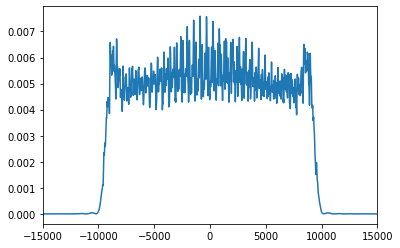

In [0]:
plt.plot(newGrid.pX, avgIrrad4)
plt.xlim((-15000, 15000))
plt.show()

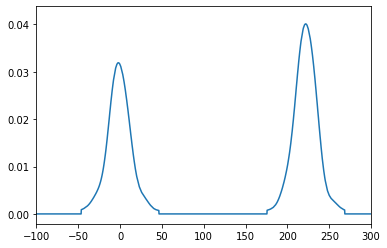

In [0]:
plt.plot(primaryGrid.px, avgIrrad5)
plt.xlim((-100, 300))
plt.show()

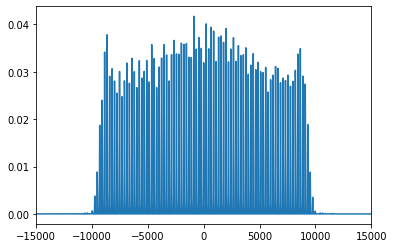

In [0]:
plt.plot(primaryGrid.px, avgIrrad5)
plt.xlim((-15000, 15000))
plt.show()

In [0]:
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords1_new.csv', grid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad1_new.csv', avgIrrad1)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords2_new.csv', newGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad2_new.csv', avgIrrad2)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords3_new.csv', newGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad3_new.csv', avgIrrad3)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords4_new.csv', newGrid.pX)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad4_new.csv', avgIrrad4)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords5_new.csv', primaryGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad5_new.csv', avgIrrad5)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/x-coords0_new.csv', collGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_0_BE_120_60/avgIrrad0_new.csv', avgIrrad0)

In [0]:
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords1_new_BE.csv', grid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad1_new_BE.csv', avgIrrad1)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords2_new_BE.csv', newGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad2_new_BE.csv', avgIrrad2)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords3_new_BE.csv', newGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad3_new_BE.csv', avgIrrad3)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords4_new_BE.csv', newGrid.pX)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad4_new_BE.csv', avgIrrad4)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords5_new_BE.csv', primaryGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad5_new_BE.csv', avgIrrad5)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/x-coords0_new_BE.csv', collGrid.px)
np.savetxt('/content/drive/My Drive/FIFIsim/L2_-300000_33_2001/avgIrrad0_new_BE.csv', avgIrrad0)